In [1]:
from transformers import pipeline
import torch
import os

import seaborn as sns
import matplotlib.pyplot as plt
from src.metrics import compute_score
from src.generate import model_evaluation
from scipy.stats import pearsonr

OUTPUT_FOLDER = "output/samples/en/phase_2/model/base_prompt/one_shot"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    
# model_id = "meta-llama/Llama-3.2-3B-Instruct"
model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    # device="cuda",
    device_map="auto",
)


/gpfs/projects/bsc14/code/MultiSynDS/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.73s/it]
Device set to use cuda:0


In [2]:
model_evaluation(pipe, clinical_case="He is sick and has headache and a fever", discharge_summary="He is sick and a fever", filenames=[])



No human evaluation file provided. Skipping example generation.




{'Content Relevance': 2,
 'Information Completeness': 1,
 'Clarity and Structure': 2,
 'Content Accuracy': 1,
 'Hallucinations': 4,
 'Impact of Hallucinations': 5,
 'Relevance to Practice': 2,
 'Overall Quality': 2,
 'Positive/Negative highlights of generation process': '',
 'Other comments on Generated/Original data sources': ''}

In [3]:
# Evaluate phase 1 data
from src.data import files_to_df
import os

data_path = "output/samples/en/phase_2/"
k_shot_filenames = ["31378248"]
eval_filenames = ['34530632', '32997782', '30785587', '26989133', '29617510', '30072860', '30930460', '31049155', '31056078', '31204375', '31486515', '31512669', '31557359']
human_eval_file="output/samples/en/phase_2/human_eval.csv"
base_filenames_path="output/samples/en/phase_2"

sample_df_gen = files_to_df(os.path.join(data_path, "generated"))
sample_df_gen["filenameid"] = sample_df_gen["filenameid"].str.replace("_transformed_step1", "")

sample_df_orig = files_to_df(os.path.join(data_path, "original"))
sample_df = sample_df_orig.merge(sample_df_gen, on="filenameid", suffixes=("_orig", "_gen"))

sample_df = sample_df[sample_df["filenameid"].isin(eval_filenames)]
sample_df

,filenameid,text_orig,text_gen
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...
7,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...
8,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...
12,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...
13,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...
14,31557359,"A 61‐year‐old man, diabetic and hypertensive, ...",**Discharge Summary**\n\n**Patient Information...
15,26989133,A previously fit and healthy 75-year-old Chine...,**Discharge Summary**\n\n**Patient Information...
16,31049155,A 30-year-old woman with a history of neonatal...,**Discharge Summary**\n\n**Patient Information...
21,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...


In [4]:

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

filenames = []
d_gen = sample_df.progress_apply(lambda x: model_evaluation(pipe, x["text_orig"], x["text_gen"], k_shot_filenames, "hf", human_eval_file=human_eval_file, base_filenames_path=base_filenames_path),
                                    axis=1)


100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


In [5]:
df_metrics = pd.DataFrame(d_gen.tolist(), index=sample_df.index)
df_model_eval = pd.concat([sample_df, df_metrics], axis=1)
df_model_eval

,filenameid,text_orig,text_gen,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive/Negative highlights of generation process,Other comments on Generated/Original data sources
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Omitted information: ECG Holter and EKG after ...,Unknown
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,"Highly accurate in the diagnosis, but omitted ...",Unknown
7,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,"Highly accurate in the diagnosis, but omitted ...",Unknown
8,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,"Highly accurate in the diagnosis, but omitted ...",Unknown
12,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Omitted information: ECG Holter and EKG after ...,Unknown
13,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,"Highly accurate in the diagnosis, omitted info...",Unknown
14,31557359,"A 61‐year‐old man, diabetic and hypertensive, ...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Omitted information: ECG Holter and EKG after ...,Unknown
15,26989133,A previously fit and healthy 75-year-old Chine...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,"Highly accurate in the diagnosis, excellent ov...",Unknown
16,31049155,A 30-year-old woman with a history of neonatal...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,"Highly accurate in the diagnosis, excellent ov...",Unknown
21,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,"Highly accurate in the diagnosis, omitted info...",Unknown


In [6]:
df_model_eval.to_csv(os.path.join(OUTPUT_FOLDER, "model_evaluation.csv"), index=False)

# Load Human Evaluation

In [7]:
he_path = "output/samples/en/phase_2/human_eval.csv"
df_human_eval = pd.read_csv(he_path)
df_human_eval = df_human_eval.iloc[:, 2:]
df_human_eval.columns = ["filenameid", 'Content Relevance', 'Information Completeness', 'Clarity and Structure', 'Content Accuracy',\
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice', 'Overall Quality',\
       'Positive highlights of generation process', 'Negative highlights of generation process', 'Other comments on Generated/Original data sources'\
       ]
df_human_eval["filenameid"] = df_human_eval["filenameid"].astype(str) 
df_human_eval = df_human_eval[df_human_eval["filenameid"].isin(eval_filenames)]
df_human_eval

,filenameid,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights of generation process,Negative highlights of generation process,Other comments on Generated/Original data sources
1,34530632,5,4,5,5,1,1,5,4,Very good performance in general.,"Lack of some information e.g., desfibrillator ...",NaN
2,32997782,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",NaN
4,30785587,1,1,2,2,1,1,1,2,NaN,Too much information omitted and the text is o...,NaN
5,26989133,5,4,5,5,1,1,5,5,NaN,NaN,NaN
6,29617510,4,4,4,5,1,1,5,4,NaN,"falta información sobre tipo de prótesis, ause...",NaN
7,30072860,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,NaN
8,30930460,4,3,4,3,1,1,3,3,NaN,falta información: mencionar estudio de trombo...,NaN
9,31049155,5,5,5,5,1,1,5,5,NaN,NaN,NaN
10,31056078,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,NaN
11,31204375,4,3,4,4,1,1,4,4,NaN,Se pierde mucha información sobre la explicaci...,NaN


In [8]:
print(df_human_eval["filenameid"].unique().tolist())

['34530632', '32997782', '30785587', '26989133', '29617510', '30072860', '30930460', '31049155', '31056078', '31204375', '31486515', '31512669', '31557359']


In [9]:
auto_path = "output/samples/en/phase_2/phase_2.csv"
df_auto = pd.read_csv(auto_path).rename(columns={"filename": "filenameid"})
df_auto["filenameid"] = df_auto["filenameid"].astype(str)
df_auto = df_auto.drop(columns=["cluster"])
df_auto = df_auto[df_auto["filenameid"].isin(eval_filenames)]
df_auto.dtypes

filenameid     object
precision     float64
recall        float64
f1            float64
tp              int64
fp              int64
fn              int64
dtype: object

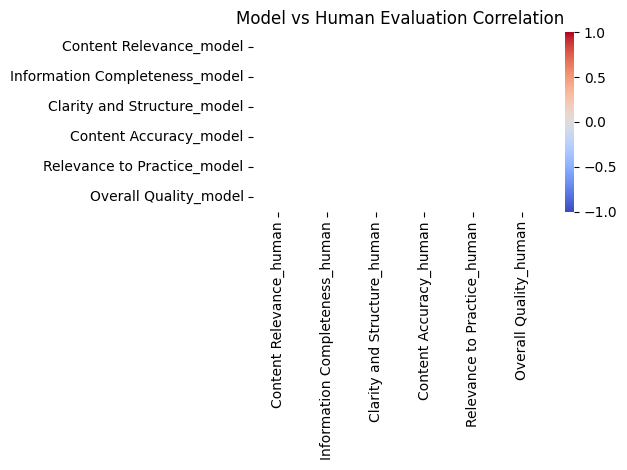

In [10]:
df_total = df_model_eval.merge(df_human_eval, on="filenameid", suffixes=("_model", "_human"))
df_total = df_total.merge(df_auto, on="filenameid")
df_total_num = df_total.select_dtypes(int)

nan_cols = ["Hallucinations_model", "Impact of Hallucinations_model", "Hallucinations_human", "Impact of Hallucinations_human"]

human_cols = [col for col in df_total_num.columns if "human" in col and col not in nan_cols]
model_cols = [col for col in df_total_num.columns if "model" in col and col not in nan_cols]

model_human_corr = df_total_num.corr().loc[model_cols, human_cols]

sns.heatmap(model_human_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Model vs Human Evaluation Correlation");
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "model_human_corr.png"), dpi=300)

In [11]:
pearsonr(df_total["Overall Quality_model"], df_total["Overall Quality_human"])

/scratch/tmp/ipykernel_3682317/1850672205.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(df_total["Overall Quality_model"], df_total["Overall Quality_human"])


PearsonRResult(statistic=nan, pvalue=nan)

# Auto Evaluation

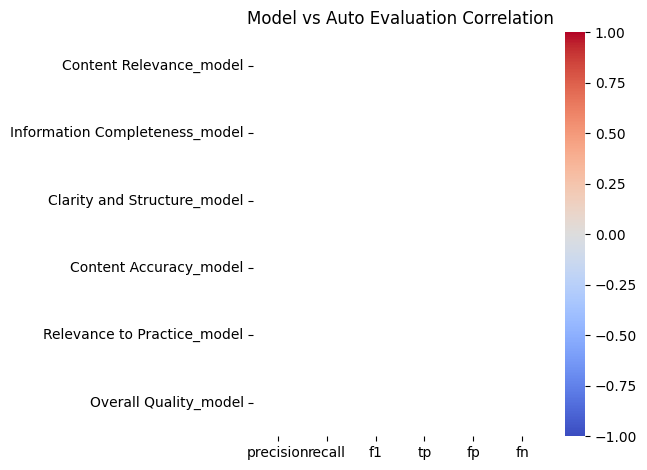

In [12]:
import numpy as np

auto_cols = df_auto.select_dtypes(np.number).columns

model_auto_corr = df_total.select_dtypes(np.number).corr().loc[model_cols, auto_cols]

sns.heatmap(model_auto_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Model vs Auto Evaluation Correlation");

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "model_auto_corr.png"), dpi=300)

In [13]:
pearsonr(df_total["f1"], df_total["Overall Quality_model"])

/scratch/tmp/ipykernel_3682317/1266032647.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(df_total["f1"], df_total["Overall Quality_model"])


PearsonRResult(statistic=nan, pvalue=nan)

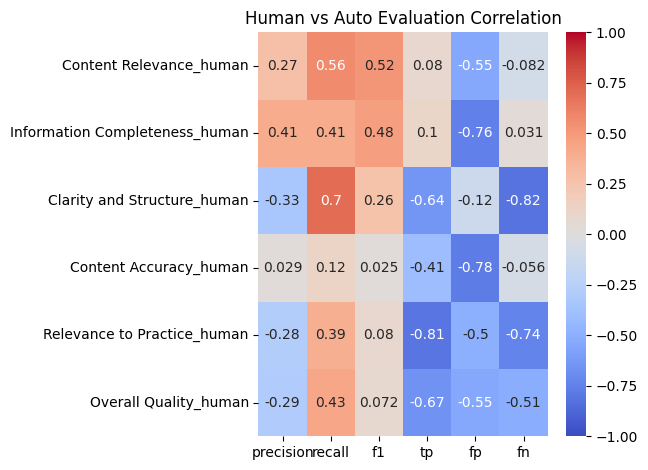

In [14]:
# Now human versus auto

human_auto_corr = df_total.select_dtypes(np.number).corr().loc[human_cols, auto_cols]

sns.heatmap(human_auto_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Human vs Auto Evaluation Correlation");

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "human_auto_corr.png"), dpi=300)

In [15]:
from scipy.stats import pearsonr
def compute_score(df_auto, df_human, col_auto, col_human):
    return pearsonr(df_auto[col_auto], df_human[col_human])

compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_human")

PearsonRResult(statistic=0.32947607723927924, pvalue=0.3865879552281516)

In [16]:
compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_model")

/scratch/tmp/ipykernel_3682317/3762423379.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(df_auto[col_auto], df_human[col_human])


PearsonRResult(statistic=nan, pvalue=nan)

In [17]:
compute_score(df_total, df_total, col_auto="Overall Quality_human", col_human="Overall Quality_model")

/scratch/tmp/ipykernel_3682317/3762423379.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(df_auto[col_auto], df_human[col_human])


PearsonRResult(statistic=nan, pvalue=nan)

# Metrics

In [18]:
pearson_auto_human = compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_human")
pearson_auto_model = compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_model")
pearson_human_model = compute_score(df_total, df_total, col_auto="Overall Quality_human", col_human="Overall Quality_model")

df_metrics_pearson = pd.DataFrame([pearson_auto_human, pearson_auto_model, pearson_human_model], columns=["pearson", "p-value"], index=["auto_human", "auto_model", "human_model"])
df_metrics_pearson.to_csv(os.path.join(OUTPUT_FOLDER, "pearson_metrics.csv"))

/scratch/tmp/ipykernel_3682317/3762423379.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(df_auto[col_auto], df_human[col_human])


In [19]:
df_metrics_pearson

,pearson,p-value
auto_human,0.329476,0.386588
auto_model,NaN,NaN
human_model,NaN,NaN


In [21]:
df_total.select_dtypes(np.number).to_csv("tmp.csv")